## Imports

In [1]:
import numpy as np
import random
import time
import gymnasium as gym
import torch
from evogym.envs import *
from evogym import EvoViewer, get_full_connectivity
from neural_controller import NeuralController, set_weights
import matplotlib.pyplot as plt
import pandas as pd
import utils

SEED = [42,43,44,45,46]

## Utils

In [2]:
def run_experiment(algorithm, num_runs=5, num_generations=100, scenario='DownStepper-v0', steps=500, algorithm_name=None, SEED=None):
    """
    Run an evolutionary algorithm multiple times and store key results.

    Parameters:
        algorithm (function): The function that runs an evolutionary algorithm (e.g., `genetic_algorithm`).
        num_runs (int): Number of times to run the algorithm.
        num_generations (int): Number of generations per run.
        scenario (str): Environment scenario.
        steps (int): Number of steps per simulation.
        algorithm_name (str or None): Algorithm name for file labeling.
        SEED (list of int or None): List of seeds for reproducibility.

    Returns:
        best_overall_weights (list): Best neural network weights found across all runs.
        best_overall_fitness (float): Best fitness score found across all runs.
        mean_fitness_per_generation (np.array): Mean best fitness per generation across all runs.
        mean_fitnesses (np.array): Mean of mean fitness scores per generation.
        mean_execution_time (float): Mean execution time across all runs.
        std_fitnesses (np.array): Standard deviation of fitness scores per generation.
    """

    # Initialize storage variables
    best_fitnesses_overall = np.zeros(num_generations)
    mean_fitnesses = np.zeros(num_generations)
    std_fitnesses = np.zeros(num_generations)

    total_execution_time = 0
    best_overall_fitness = float('-inf')
    best_overall_weights = None

    if SEED is None:
        SEED = [random.randint(0, 9999) for _ in range(num_runs)]

    for i in range(num_runs):
        random.seed(SEED[i])
        np.random.seed(SEED[i])
        torch.manual_seed(SEED[i])

        print(f"\nRunning {algorithm.__name__} {i + 1}/{num_runs}...")

        best_weights, best_fitness, best_fitness_scores, mean_fitnesses_run, execution_time, std_fitness_scores_run = algorithm()

        print(f"Best fitness score of run {i + 1}: {best_fitness:.3f}")

        # Accumulate fitness data
        best_fitnesses_overall += np.array(best_fitness_scores)
        mean_fitnesses += np.array(mean_fitnesses_run)
        std_fitnesses += np.array(std_fitness_scores_run)

        # Track best controller
        if best_fitness > best_overall_fitness:
            best_overall_fitness = best_fitness
            best_overall_weights = best_weights

        # Save run to CSV
        df = pd.DataFrame({
            'Generation': range(num_generations),
            'Reward': best_fitness_scores,
            'Best Weights': [best_weights] * num_generations,
            'Best Fitness': best_fitness_scores,
            'Mean Fitness': mean_fitnesses_run,
            'Std Fitness': std_fitness_scores_run,
            'Execution Time': [execution_time] * num_generations
        })

        csv_name = f"{algorithm_name}_{scenario}_seed_{SEED[i]}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved run {i+1} results to {csv_name}")
        
        total_execution_time += execution_time

    # Averages across runs
    best_fitnesses_overall /= num_runs
    mean_fitnesses /= num_runs
    std_fitnesses /= num_runs
    mean_execution_time = total_execution_time / num_runs

    print("\nFinal Results After Multiple Runs:")
    print(f"Mean execution time: {mean_execution_time:.2f} seconds")
    print(f"Best fitness found: {best_overall_fitness:.3f}")

    # Plot fitness evolution
    plt.figure(figsize=(10, 5))
    plt.plot(best_fitnesses_overall, label="Mean Best Fitness", color='blue')
    plt.fill_between(range(num_generations),
                     best_fitnesses_overall - std_fitnesses,
                     best_fitnesses_overall + std_fitnesses,
                     color='blue', alpha=0.2, label='Std Dev Range')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(f"{algorithm_name}: Fitness Evolution in {scenario}")
    plt.legend()
    plt.grid()
    plt.show()

    return best_overall_weights, best_overall_fitness, best_fitnesses_overall, mean_fitnesses, mean_execution_time, std_fitnesses


In [3]:
# ---- VISUALIZATION ----
def visualize_policy(weights):
    set_weights(brain, weights)  # Load weights into the network
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')
    state = env.reset()[0]  # Get initial state
    for t in range(STEPS):  
        # Update actuation before stepping
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
        action = brain(state_tensor).detach().numpy().flatten() # Get action
        viewer.render('screen') 
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            env.reset()
            break

    viewer.close()
    env.close()


## Random

In [4]:
NUM_GENERATIONS = 100  # Number of generations to evolve
POP_SIZE = 40  # Population size
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = random.randint(0, 10000)
# np.random.seed(SEED)
# random.seed(SEED)


robot_structure = np.array([ 
[1,3,1,0,0],
[4,1,3,2,2],
[3,4,4,4,4],
[3,0,0,3,2],
[0,0,0,0,2]
])



connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]  # Observation size
output_size = env.action_space.shape[0]  # Action size

brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
        set_weights(brain, weights)  # Load weights into the network
        env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
        sim = env
        viewer = EvoViewer(sim)
        viewer.track_objects('robot')
        state = env.reset()[0]  # Get initial state
        t_reward = 0
        for t in range(STEPS):  
            # Update actuation before stepping
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor
            action = brain(state_tensor).detach().numpy().flatten() # Get action
            if view:
                viewer.render('screen') 
            state, reward, terminated, truncated, info = env.step(action)
            t_reward += reward
            if terminated or truncated:
                env.reset()
                break

        viewer.close()
        env.close()
        return t_reward 


# ---- RANDOM SEARCH ALGORITHM ----
def random_search_controller():
    best_fitness = -np.inf
    best_weights = None
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        # Generate a population of random weight sets
        population = [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(POP_SIZE)]

        # Evaluate all individuals in the population
        fitnesses = [evaluate_fitness(weights) for weights in population]

        # Track best individual of this generation
        generation_best = np.max(fitnesses)
        generation_mean = np.mean(fitnesses)
        generation_std = np.std(fitnesses)

        best_fitness_scores.append(generation_best)
        mean_fitness_scores.append(generation_mean)
        std_fitness_scores.append(generation_std)

        if generation_best > best_fitness:
            best_fitness = generation_best
            best_weights = population[np.argmax(fitnesses)]

        # print(f"Generation {generation + 1}/{NUM_GENERATIONS}, Best: {generation_best:.3f}, Mean: {generation_mean:.3f}")

    execution_time = time.time() - start_time
    return best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores



Running random_search_controller 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 2.264
Saved run 1 results to random_search_DownStepper-v0_seed_42.csv

Running random_search_controller 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 2.346
Saved run 2 results to random_search_DownStepper-v0_seed_43.csv

Running random_search_controller 3/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 2.423
Saved run 3 results to random_search_DownStepper-v0_seed_44.csv

Running random_search_controller 4/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 2.176
Saved run 4 results to random_search_DownStepper-v0_seed_45.csv

Running random_search_controller 5/5...
SIMULATION UNS

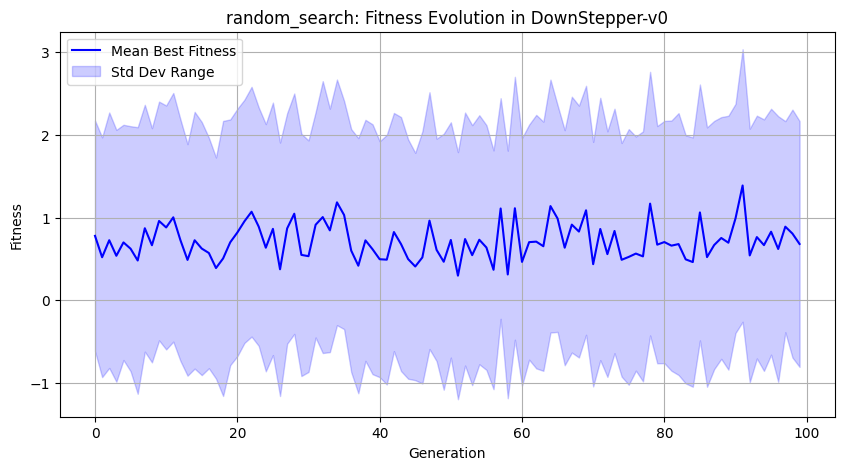

Results saved to random_search_results_DownStepper-v0.csv


In [ ]:

best_weights, best_fitness, best_curve, mean_curve, exec_time, std_curve = run_experiment(
    algorithm=random_search_controller,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='random_search',
    SEED=SEED
)

# Save to a CSV file
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_curve,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_curve,
    'Mean Fitness': mean_curve,
    'Std Fitness': std_curve,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("random_search_results_DownStepper-v0.csv", index=False)
print("Results saved to random_search_results_DownStepper-v0.csv")



Running random_search_controller 1/5...


c:\Users\PC\Desktop\MECD\CE\.venv\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment ObstacleTraverser-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Best fitness score of run 1: 1.859
Saved run 1 results to random_search_ObstacleTraverser-v0_seed_42.csv

Running random_search_controller 2/5...
Best fitness score of run 2: 1.786
Saved run 2 results to random_search_ObstacleTraverser-v0_seed_43.csv

Running random_search_controller 3/5...
Best fitness score of run 3: 1.771
Saved run 3 results to random_search_ObstacleTraverser-v0_seed_44.csv

Running random_search_controller 4/5...
Best fitness score of run 4: 1.824
Saved run 4 results to random_search_ObstacleTraverser-v0_seed_45.csv

Running random_search_controller 5/5...
Best fitness score of run 5: 1.626
Saved run 5 results to random_search_ObstacleTraverser-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 8360.81 seconds
Best fitness found: 1.859


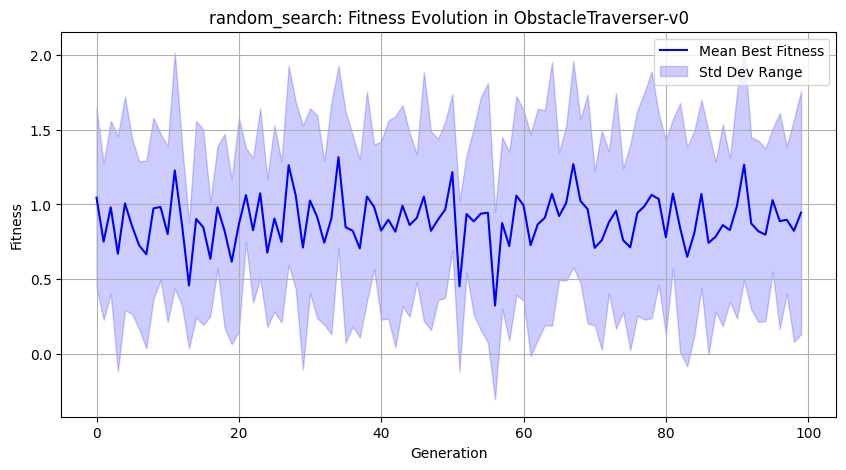

Results saved to random_search_results_ObstacleTraverser-v0.csv


In [8]:

# Change the scenario 
SCENARIO = 'ObstacleTraverser-v0'
best_weights, best_fitness, best_curve, mean_curve, exec_time, std_curve = run_experiment(
    algorithm=random_search_controller,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='random_search',
    SEED=SEED
)

# Save to a CSV file
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_curve,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_curve,
    'Mean Fitness': mean_curve,
    'Std Fitness': std_curve,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("random_search_results_ObstacleTraverser-v0.csv", index=False)
print("Results saved to random_search_results_ObstacleTraverser-v0.csv")

## If you want to see the robot move, use this

In [37]:

# Set the best weights found
set_weights(brain, best_weights)
print(f"Best Fitness: {best_fitness}")

i = 0
while i < 5:
    visualize_policy(best_weights)
    i += 1

Best Fitness: 4.183831230933563


KeyboardInterrupt: 

## Genetic Algorithm

In [5]:
# ---- PARAMETERS ----
POP_SIZE = 40
NUM_GENERATIONS = 100
MUTATION_STD = 0.1
ELITE_RATIO = 0.2
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = 42

# # ---- SEEDING ----
# np.random.seed(SEED)
# random.seed(SEED)
# torch.manual_seed(SEED)

# ---- ENVIRONMENT SETUP ----
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
env.close()

# ---- CONTROLLER INSTANCE ----
brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
    set_weights(brain, weights)
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')

    state, _ = env.reset()
    total_reward = 0

    for t in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()

        if view:
            viewer.render('screen')

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    viewer.close()
    env.close()
    return total_reward

# ---- GENETIC OPERATORS ----
def initialize_population():
    return [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(POP_SIZE)]

def mutate(individual):
    return [w + MUTATION_STD * np.random.randn(*w.shape) for w in individual]

def crossover(parent1, parent2):
    child = []
    for w1, w2 in zip(parent1, parent2):
        mask = np.random.rand(*w1.shape) < 0.5
        child_weights = np.where(mask, w1, w2)
        child.append(child_weights)
    return child

def select_parents(population, fitnesses):
    tournament_size = 3
    parents = []
    for _ in range(POP_SIZE):
        competitors = random.sample(list(zip(population, fitnesses)), tournament_size)
        best = max(competitors, key=lambda x: x[1])[0]
        parents.append(best)
    return parents

# ---- GENETIC ALGORITHM ----
def genetic_algorithm():
    population = initialize_population()
    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        fitnesses = [evaluate_fitness(ind) for ind in population]
        best_idx = np.argmax(fitnesses)

        best_fitness_scores.append(fitnesses[best_idx])
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        num_elites = int(ELITE_RATIO * POP_SIZE)
        elites = [population[i] for i in np.argsort(fitnesses)[-num_elites:]]

        parents = select_parents(population, fitnesses)
        offspring = [
            mutate(crossover(random.choice(parents), random.choice(parents)))
            for _ in range(POP_SIZE - num_elites)
        ]

        population = elites + offspring

        # print(f"Gen {generation+1}: Best = {best_fitness_scores[-1]:.2f}, Mean = {mean_fitness_scores[-1]:.2f}")

    end_time = time.time()
    execution_time = end_time - start_time

    final_fitnesses = [evaluate_fitness(ind) for ind in population]
    best_idx = np.argmax(final_fitnesses)
    best_weights = population[best_idx]
    best_fitness = final_fitnesses[best_idx]

    return best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores



Running genetic_algorithm 1/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 4.827
Saved run 1 results to genetic_algorithm_DownStepper-v0_seed_42.csv

Running genetic_algorithm 2/5...
Best fitness score of run 2: 3.002
Saved run 2 results to genetic_algorithm_DownStepper-v0_seed_43.csv

Running genetic_algorithm 3/5...
Best fitness score of run 3: 3.047
Saved run 3 results to genetic_algorithm_DownStepper-v0_seed_44.csv

Running genetic_algorithm 4/5...
Best fitness score of run 4: 3.856
Saved run 4 results to genetic_algorithm_DownStepper-v0_seed_45.csv

Running genetic_algorithm 5/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 5: 4.530
Saved run 5 results to genetic_algorithm_DownStepper-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 6848.74 seconds
Best fitness found: 4.827


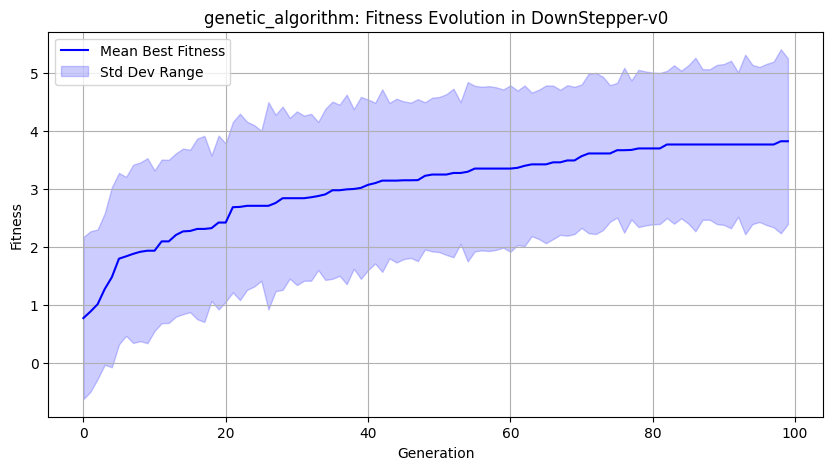

Results saved to genetic_algorithm_results_DownStepper-v0.csv

Best Fitness: 4.83
Execution Time: 6848.74 seconds


In [6]:
# ---- RUN GA AND VISUALIZE RESULT ----
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=genetic_algorithm,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='genetic_algorithm',
    SEED=SEED
    )
# print(f"\nBest Weights: {best_weights}")

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("genetic_algorithm_results_DownStepper-v0.csv", index=False)
print("Results saved to genetic_algorithm_results_DownStepper-v0.csv")


print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")



Running genetic_algorithm 1/5...


c:\Users\PC\Desktop\MECD\CE\.venv\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment ObstacleTraverser-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 2.506
Saved run 1 results to genetic_algorithm_ObstacleTraverser-v0_seed_42.csv

Running genetic_algorithm 2/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 1.898
Saved run 2 results to genetic_algorithm_ObstacleTraverser-v0_seed_43.csv

Running genetic_algorithm 3/5...
Best fitness s

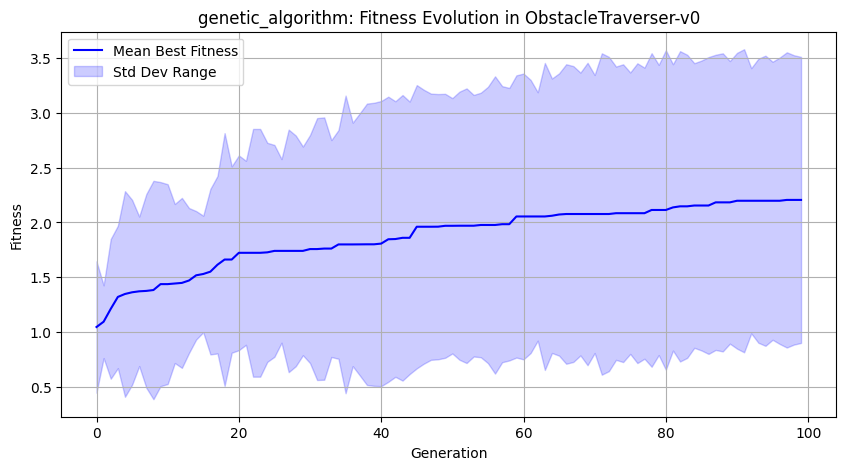


Best Fitness: 2.85
Execution Time: 7785.15 seconds


In [7]:
SCENARIO = 'ObstacleTraverser-v0'

# ---- RUN GA AND VISUALIZE RESULT ----
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=genetic_algorithm,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='genetic_algorithm',
    SEED=SEED
)
# print(f"\nBest Weights: {best_weights}")

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("genetic_algorithm_results_ObstacleTraverser-v0.csv", index=False)

print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")


## Differential Evolution

In [11]:
# ---- PARAMETERS ----
POP_SIZE = 40
NUM_GENERATIONS = 100
F = 0.5                  # Mutation scaling factor
CR = 0.7                # Crossover rate (binomial)
STEPS = 500
SCENARIO = 'DownStepper-v0'
# SEED = 42

# np.random.seed(SEED)
# random.seed(SEED)
# torch.manual_seed(SEED)

# ---- ENVIRONMENT SETUP ----
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
sim = env.sim
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
env.close()

brain = NeuralController(input_size, output_size)

# ---- FITNESS FUNCTION ----
def evaluate_fitness(weights, view=False):
    set_weights(brain, weights)
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    sim = env.sim
    viewer = EvoViewer(sim)
    viewer.track_objects('robot')

    state, _ = env.reset()
    total_reward = 0

    for t in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()

        if view:
            viewer.render('screen')

        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward

        if terminated or truncated:
            break

    viewer.close()
    env.close()
    return total_reward

# ---- HELPER FUNCTIONS ----
def initialize_population():
    return [[np.random.randn(*param.shape) for param in brain.parameters()] for _ in range(POP_SIZE)]

def vectorize(individual):
    """Flatten weights into a single 1D vector."""
    return np.concatenate([w.flatten() for w in individual])

def devectorize(vector, shapes):
    """Convert 1D vector back into individual weight structure."""
    individual = []
    idx = 0
    for shape in shapes:
        size = np.prod(shape)
        values = vector[idx:idx + size].reshape(shape)
        individual.append(values)
        idx += size
    return individual

def binomial_crossover(target, mutant, cr):
    """Perform binomial crossover ensuring at least one gene changes."""
    size = len(target)
    trial = np.copy(target)
    rand_index = random.randint(0, size - 1)
    for i in range(size):
        if random.random() < cr or i == rand_index:
            trial[i] = mutant[i]
    return trial

# ---- DIFFERENTIAL EVOLUTION ----
def differential_evolution():
    population = initialize_population()
    shapes = [w.shape for w in population[0]]  # Save weight shapes
    pop_vectors = [vectorize(ind) for ind in population]
    fitnesses = [evaluate_fitness(devectorize(v, shapes)) for v in pop_vectors]

    best_fitness_scores = []
    mean_fitness_scores = []
    std_fitness_scores = []

    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        new_population = []
        for i in range(POP_SIZE):
            # Choose three distinct individuals
            indices = list(range(POP_SIZE))
            indices.remove(i)
            a, b, c = random.sample(indices, 3)

            base = pop_vectors[a]
            diff = pop_vectors[b] - pop_vectors[c]
            mutant = base + F * diff

            target = pop_vectors[i]
            trial = binomial_crossover(target, mutant, CR)
            trial_ind = devectorize(trial, shapes)

            trial_fitness = evaluate_fitness(trial_ind)
            if trial_fitness > fitnesses[i]:
                new_population.append(trial)
                fitnesses[i] = trial_fitness
            else:
                new_population.append(target)  # keep original

        pop_vectors = new_population

        best = np.max(fitnesses)
        mean = np.mean(fitnesses)
        std = np.std(fitnesses)

        best_fitness_scores.append(best)
        mean_fitness_scores.append(mean)
        std_fitness_scores.append(std)

        # print(f"Gen {generation+1}: Best = {best:.2f}, Mean = {mean:.2f}")

    end_time = time.time()
    execution_time = end_time - start_time

    best_idx = np.argmax(fitnesses)
    best_vector = pop_vectors[best_idx]
    best_weights = devectorize(best_vector, shapes)

    return best_weights, fitnesses[best_idx], best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores


Running differential_evolution 1/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 4.184
Saved run 1 results to diferential_evolution_DownStepper-v0_seed_42.csv

Running differential_evolution 2/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 2: 2.672
Saved run 2 results to diferential_evolution_DownStepper-v0_seed_43.csv

Running differential_evolution 3/5...
Best fitness score of run 3: 3.472
Saved run 3 results to diferential_evolution_DownStepper-v0_seed_44.csv

Running differential_evolution 4/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 3.004
Saved run 4 results to diferential_evolution_DownStepper-v0_seed_45.csv

Running differential_evolution 5/5...
SIMULATION UNSTABLE... TERMINATING
SIMULATION UNSTABLE... TERM

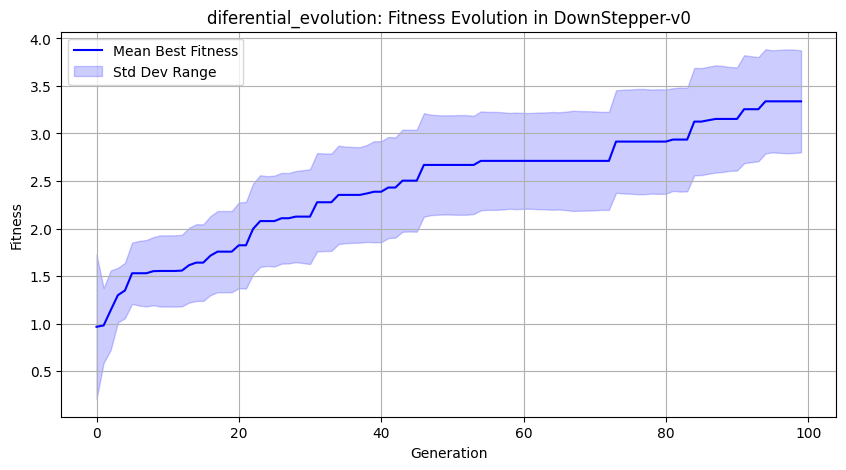

Results saved to differential_evolution_results_DownStepper-v0.csv

Best Fitness: 4.18
Execution Time: 6101.56 seconds


In [9]:
# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=differential_evolution,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='diferential_evolution',
    SEED=SEED
)

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("differential_evolution_results_DownStepper-v0.csv", index=False)
print("Results saved to differential_evolution_results_DownStepper-v0.csv")


# print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")



Running differential_evolution 1/5...


c:\Users\PC\Desktop\MECD\CE\.venv\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment ObstacleTraverser-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 1: 1.576
Saved run 1 results to diferential_evolution_ObstacleTraverser-v0_seed_42.csv

Running differential_evolution 2/5...
Best fitness score of run 2: 1.849
Saved run 2 results to diferential_evolution_ObstacleTraverser-v0_seed_43.csv

Running differential_evolution 3/5...
Best fitness score of run 3: 1.869
Saved run 3 results to diferential_evolution_ObstacleTraverser-v0_seed_44.csv

Running differential_evolution 4/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 4: 1.626
Saved run 4 results to diferential_evolution_ObstacleTraverser-v0_seed_45.csv

Running differential_evolution 5/5...
Best fitness score of run 5: 1.864
Saved run 5 results to diferential_evolution_ObstacleTraverser-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 8236.86 seconds
Best fitness found: 1.869


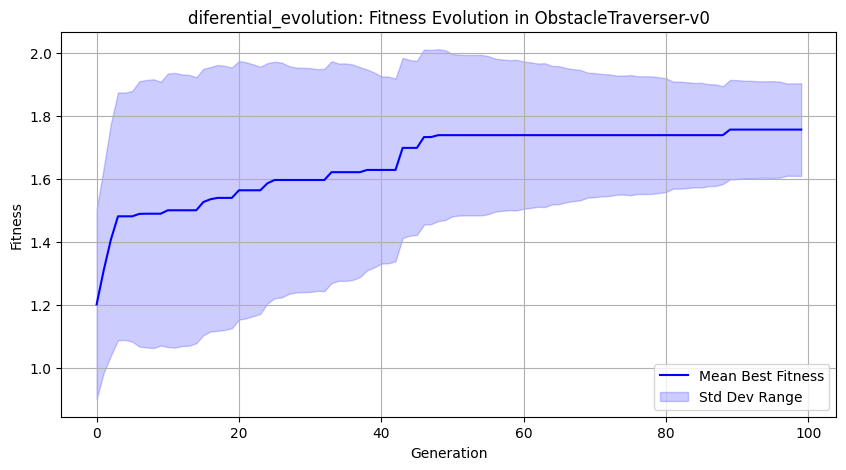

Results saved to differential_evolution_results_ObstacleTraverser-v0.csv

Best Fitness: 1.87
Execution Time: 8236.86 seconds


In [8]:
# Change the scenario
SCENARIO = 'ObstacleTraverser-v0'

# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=differential_evolution,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='diferential_evolution',
    SEED=SEED
)

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("differential_evolution_results_ObstacleTraverser-v0.csv", index=False)
print("Results saved to differential_evolution_results_ObstacleTraverser-v0.csv")


# print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")


Maus resultados.
Increase mutation factor F (0.7)
- Promotes exploration and helps escape plateaus.

Lower crossover rate CR (0.5)
- Reduces disruptive recombination in noisy environments.

Nota: Future work se não tiver tempo

## Guess What, I got time :)


Running differential_evolution 1/5...


c:\Users\PC\Desktop\MECD\CE\.venv\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment ObstacleTraverser-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Best fitness score of run 1: 1.791
Saved run 1 results to diferential_evolution_tuned_ObstacleTraverser-v0_seed_42.csv

Running differential_evolution 2/5...
Best fitness score of run 2: 1.801
Saved run 2 results to diferential_evolution_tuned_ObstacleTraverser-v0_seed_43.csv

Running differential_evolution 3/5...
SIMULATION UNSTABLE... TERMINATING
Best fitness score of run 3: 1.855
Saved run 3 results to diferential_evolution_tuned_ObstacleTraverser-v0_seed_44.csv

Running differential_evolution 4/5...
Best fitness score of run 4: 1.765
Saved run 4 results to diferential_evolution_tuned_ObstacleTraverser-v0_seed_45.csv

Running differential_evolution 5/5...
Best fitness score of run 5: 1.887
Saved run 5 results to diferential_evolution_tuned_ObstacleTraverser-v0_seed_46.csv

Final Results After Multiple Runs:
Mean execution time: 9168.67 seconds
Best fitness found: 1.887


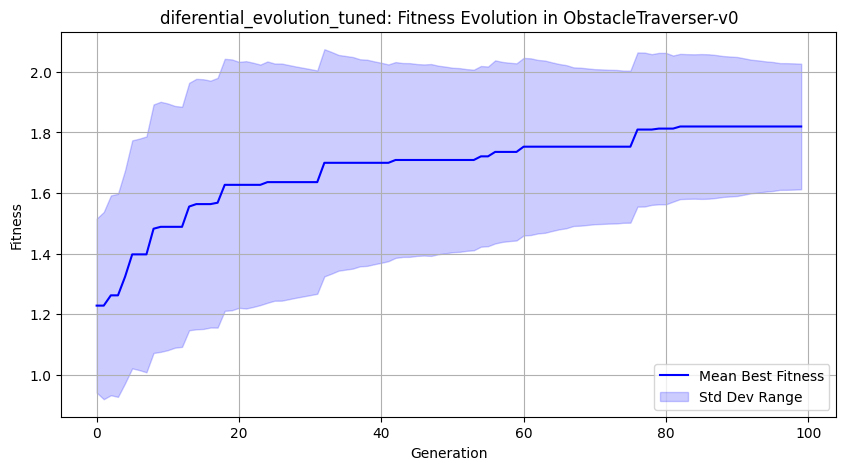

Results saved to differential_evolution_tuned_results_ObstacleTraverser-v0.csv

Best Fitness: 1.89
Execution Time: 9168.67 seconds


In [12]:
# 
# Change the scenario
SCENARIO = 'ObstacleTraverser-v0'

# Change the parameters we can for DE
F = 0.7                  # Mutation scaling factor
CR = 0.5                # Crossover rate (binomial)

# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=differential_evolution,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='diferential_evolution_tuned',
    SEED=SEED
)

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("differential_evolution_tuned_results_ObstacleTraverser-v0.csv", index=False)
print("Results saved to differential_evolution_tuned_results_ObstacleTraverser-v0.csv")


# print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")


## CMA-ES

In [13]:
# --- PARAMETERS ---
POP_SIZE = 40
NUM_GENERATIONS = 100
ELITE_RATIO = 0.2
SIGMA_INIT = 0.3
SCENARIO = 'DownStepper-v0'
STEPS = 500

# --- ENVIRONMENT SETUP ---
robot_structure = np.array([
    [1, 3, 1, 0, 0],
    [4, 1, 3, 2, 2],
    [3, 4, 4, 4, 4],
    [3, 0, 0, 3, 2],
    [0, 0, 0, 0, 2]
])

connectivity = get_full_connectivity(robot_structure)
env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
input_size = env.observation_space.shape[0]
output_size = env.action_space.shape[0]
env.close()

brain = NeuralController(input_size, output_size)
shapes = [p.shape for p in brain.parameters()]
dim = sum(np.prod(s) for s in shapes)

# --- Weight Utils ---
def vectorize(weights):
    return np.concatenate([w.flatten() for w in weights])

def devectorize(vec, shapes):
    weights = []
    idx = 0
    for shape in shapes:
        size = np.prod(shape)
        weights.append(vec[idx:idx + size].reshape(shape))
        idx += size
    return weights

# --- Fitness Function ---
def evaluate_fitness(weights, view=False):
    set_weights(brain, weights)
    env = gym.make(SCENARIO, max_episode_steps=STEPS, body=robot_structure, connections=connectivity)
    viewer = EvoViewer(env) if view else None
    if viewer: viewer.track_objects('robot')

    state, _ = env.reset()
    total_reward = 0

    for _ in range(STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = brain(state_tensor).detach().numpy().flatten()
        if view: viewer.render('screen')
        state, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        if terminated or truncated: break

    if viewer: viewer.close()
    env.close()
    return total_reward

# --- CMA-ES Core ---
def cma_es():
    # Initialization
    mean = np.random.randn(dim) * 0.1  # Small random start
    sigma = SIGMA_INIT
    diag_cov = np.ones(dim)  # Diagonal-only covariance (std devs squared)

    best_fitness_scores, mean_fitness_scores, std_fitness_scores = [], [], []
    start_time = time.time()

    for generation in range(NUM_GENERATIONS):
        # Sample population
        population = np.random.randn(POP_SIZE, dim) * np.sqrt(diag_cov) * sigma + mean
        weights_list = [devectorize(ind, shapes) for ind in population]
        fitnesses = [evaluate_fitness(weights) for weights in weights_list]

        fitnesses = np.array(fitnesses)
        best_fitness_scores.append(np.max(fitnesses))
        mean_fitness_scores.append(np.mean(fitnesses))
        std_fitness_scores.append(np.std(fitnesses))

        # Elites
        num_elite = int(ELITE_RATIO * POP_SIZE)
        elite_indices = np.argsort(fitnesses)[-num_elite:]
        elite_samples = population[elite_indices]

        # Update mean and variance
        mean = elite_samples.mean(axis=0)
        diag_cov = np.var(elite_samples, axis=0) + 1e-8  # Avoid collapse

        # Step size schedule (simple decay)
        sigma *= 0.99

    execution_time = time.time() - start_time
    best_idx = np.argmax(fitnesses)
    best_weights = devectorize(population[best_idx], shapes)

    return best_weights, fitnesses[best_idx], best_fitness_scores, mean_fitness_scores, execution_time, std_fitness_scores


In [ ]:
# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=cma_es,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='cma_es',
    SEED=SEED
)

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})

df.to_csv("cma_es_results_DownStepper-v0.csv", index=False)
print("Results saved to cma_es_results_DownStepper-v0.csv")


# print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")



Running cma_es 1/5...
Best fitness score of run 1: 0.113
Saved run 1 results to cma_es_DownStepper-v0_seed_42.csv

Running cma_es 2/5...
Best fitness score of run 2: 0.034
Saved run 2 results to cma_es_DownStepper-v0_seed_43.csv

Running cma_es 3/5...
Best fitness score of run 3: 0.248
Saved run 3 results to cma_es_DownStepper-v0_seed_44.csv

Running cma_es 4/5...
Best fitness score of run 4: 0.409
Saved run 4 results to cma_es_DownStepper-v0_seed_45.csv

Running cma_es 5/5...
SIMULATION UNSTABLE... TERMINATING


Results so bad i wont even test it on the next scenario.

In [ ]:
# Change the scenario
SCENARIO = 'ObstacleTraverser-v0'

# RUN DE AND VISUALIZE RESULT
best_weights, best_fitness, best_fitness_scores, mean_fitness_scores, exec_time, std_fitness = run_experiment(
    algorithm=cma_es,
    num_runs=5,
    num_generations=NUM_GENERATIONS,
    scenario=SCENARIO,
    steps=STEPS,
    algorithm_name='cma_es',
    SEED=SEED
)

# Save to a CSV File
df = pd.DataFrame({
    'Generation': range(NUM_GENERATIONS),
    'Reward': best_fitness_scores,
    'Best Overall Fitness': [best_fitness] * NUM_GENERATIONS,
    'Best Weights': [best_weights] * NUM_GENERATIONS,
    'Best Fitness': best_fitness_scores,
    'Mean Fitness': mean_fitness_scores,
    'Std Fitness': std_fitness,
    'Execution Time': [exec_time] * NUM_GENERATIONS
})
df.to_csv("cma_es_results_ObstacleTraverser-v0.csv", index=False)
print("Results saved to cma_es_results_ObstacleTraverser-v0.csv")

# print(f"\nBest Weights: {best_weights}")
print(f"\nBest Fitness: {best_fitness:.2f}")
print(f"Execution Time: {exec_time:.2f} seconds")